# Installation des packages

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
!pip install numpy==1.21.0 --quiet
!pip install pandas==1.5.2 --quiet
!pip install plotly==5.11.0 --quiet
!pip install scikit-learn==1.2.0 --quiet
!pip install scikit-optimize==0.9.0 --quiet
!pip install statsmodels==0.13.5 --quiet
!pip install category_encoders==2.5.1 --quiet
!pip install xgboost==1.7.2 --quiet
!pip install projectpro --upgrade --quiet
!pip install nbformat==5.7.1 --quiet
!pip install matplotlib==3.6.2 --quiet

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import sys
from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.preprocessing import  PowerTransformer
from sklearn.feature_selection import RFE
import projectpro


In [3]:
sys.path.append('mon_package/')
from EDA import plot_histograms, plot_univariate_numeric, plot_univariate_categorical, \
plot_heatmap, plot_paired_boxplots, plot_paired_scatterplots, plot_residuals, plot_pearson_wrt_target
from TestsStatistiques import chi2, anova
from EvaluationDeModèle import calc_model_performance, compare_model_performance, calc_preds_in_residual_range, calc_preds_in_residual_perc_range

# **Analyse exploitoire de données**

In [4]:
data = pd.read_csv('data.csv')

In [9]:
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
X = data.drop('charges', axis=1)
y = data['charges']

In [13]:
X.shape, y.shape

((1338, 6), (1338,))

## Distributions des variables

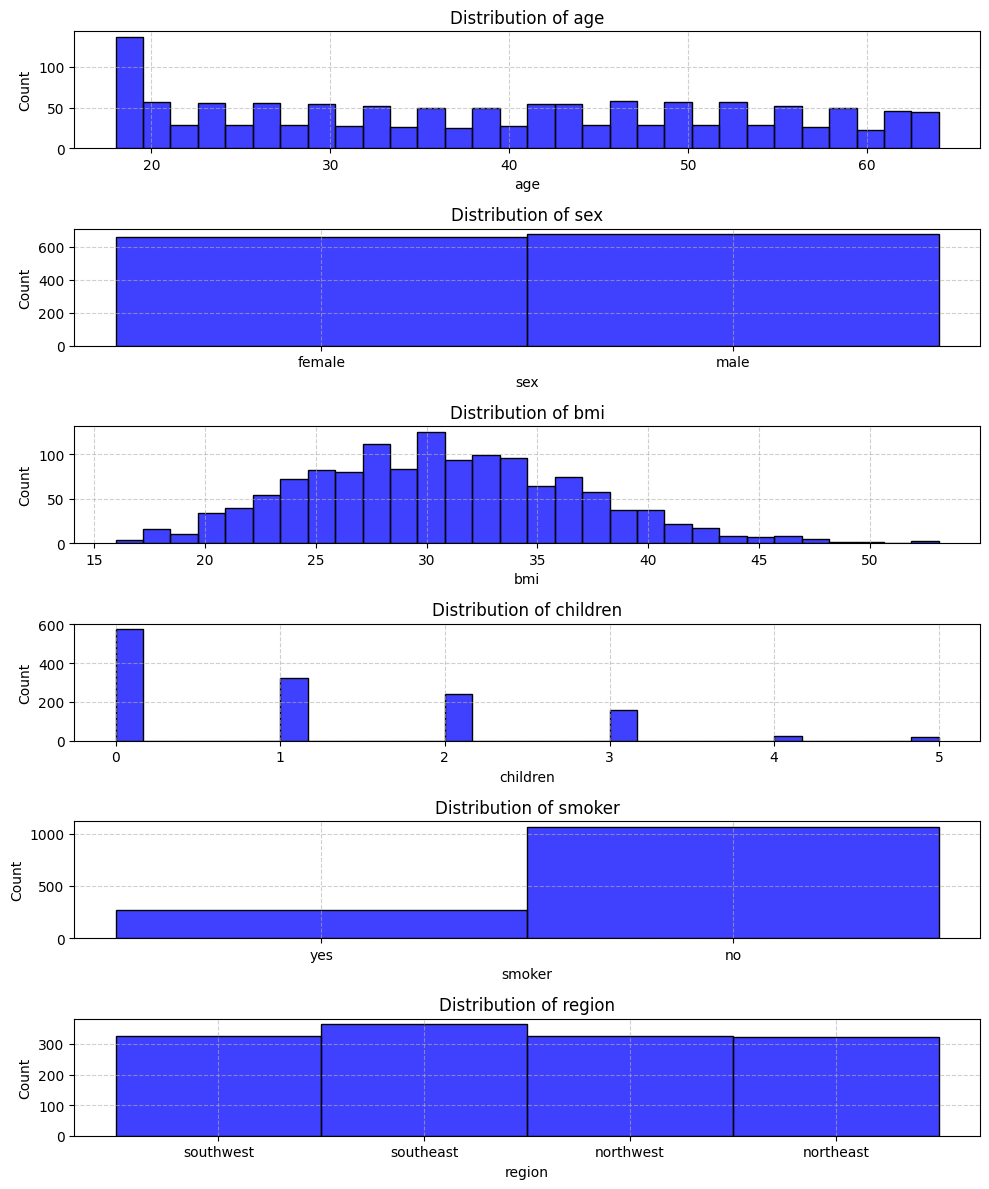

In [15]:
plot_histograms(X)

* `age` - Approximativement uniformément distribué.
* `sex` - Volume approximativement égal dans chaque catégorie.
* `bmi` -  Approximativement distribué normalement.
* `children` - Asymétrie à droite.
* `smoker` - Dominance  dans la catégorie no par rapport à la catégorie yes.
* `region` - Approximativement égal dans chaque catégorie

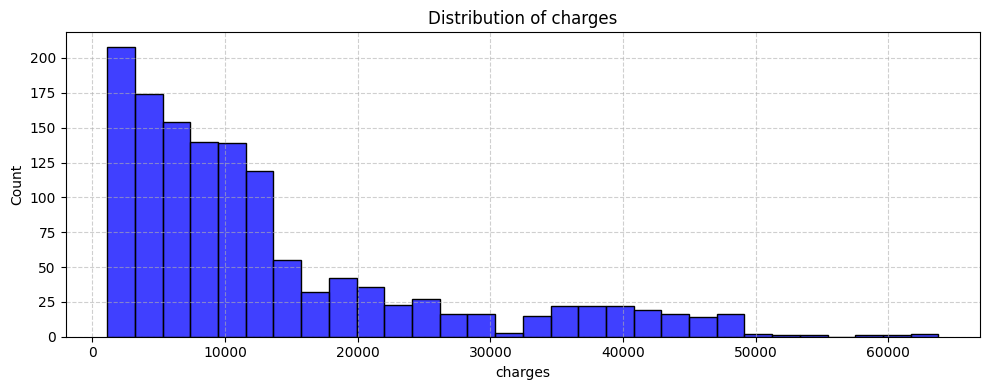

In [26]:
plot_histograms(pd.DataFrame(y), height=400)

## Analyse univariée des variables explicatives  par rapports à la variable cible

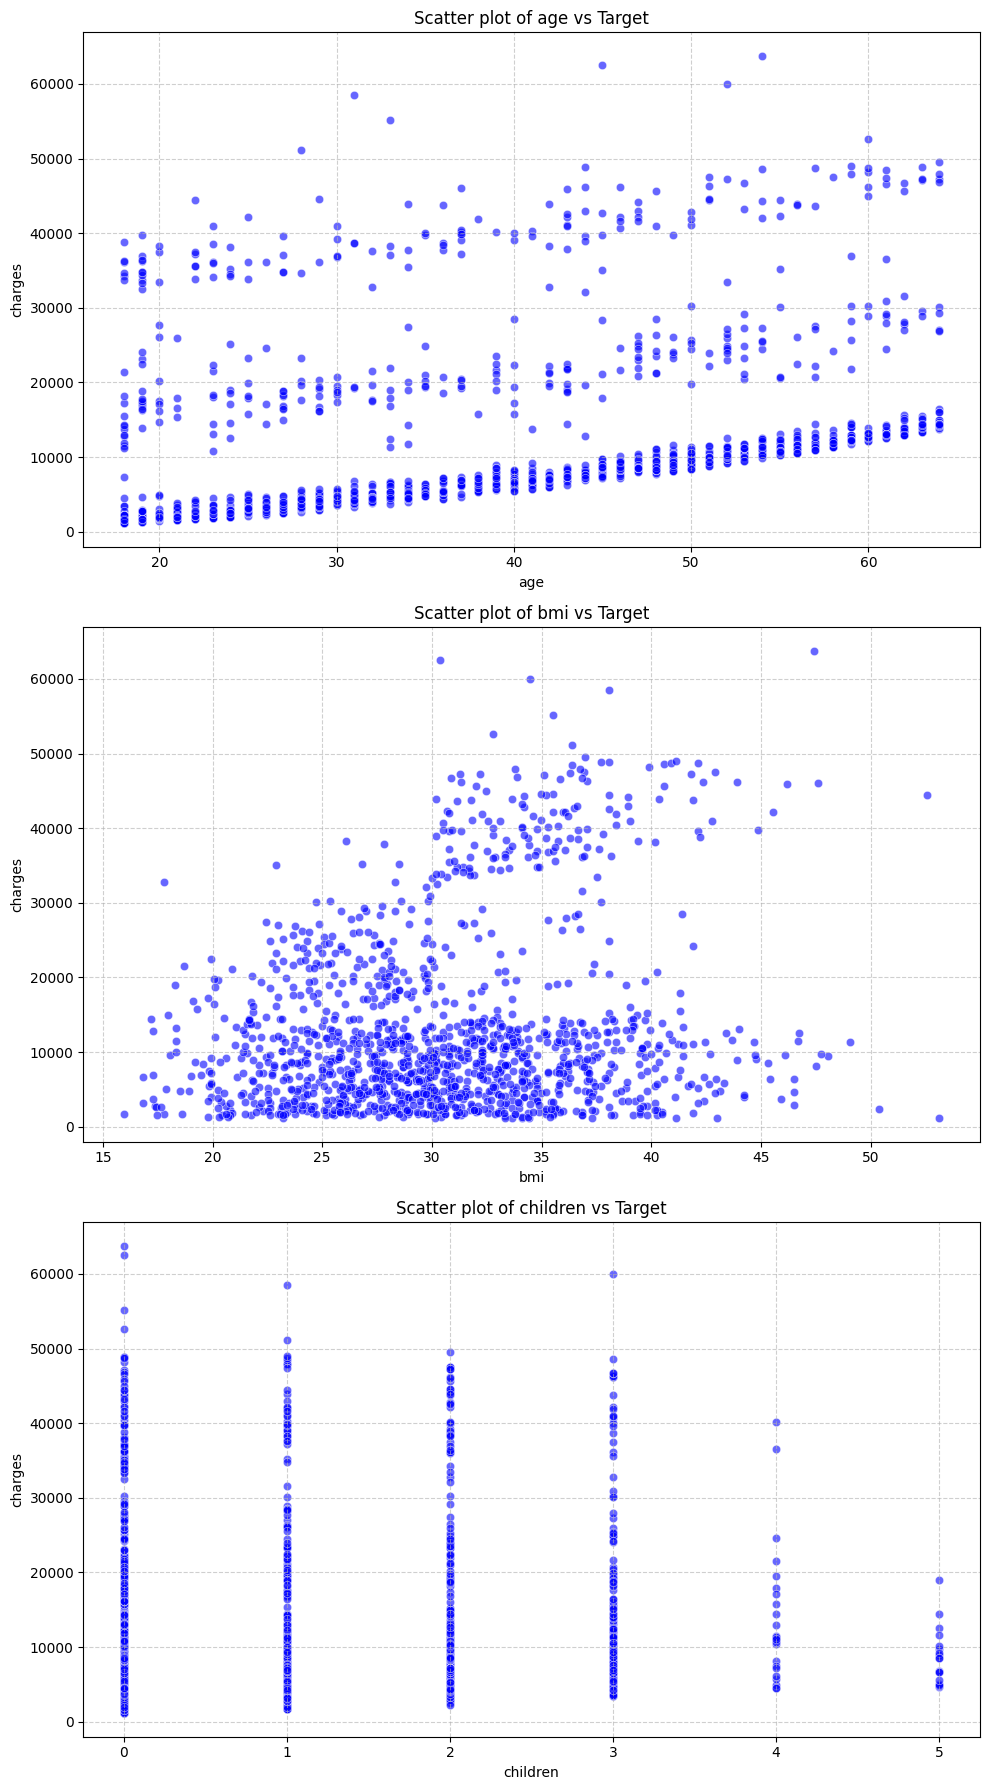

In [27]:
# Les variables numériques
plot_univariate_numeric(X.select_dtypes(include=np.number), y)

* `age` - Tant que `age` augmente, également `charges` augmente
* `bmi` - Aucune relation claire
* `children` - Aucune relation claire

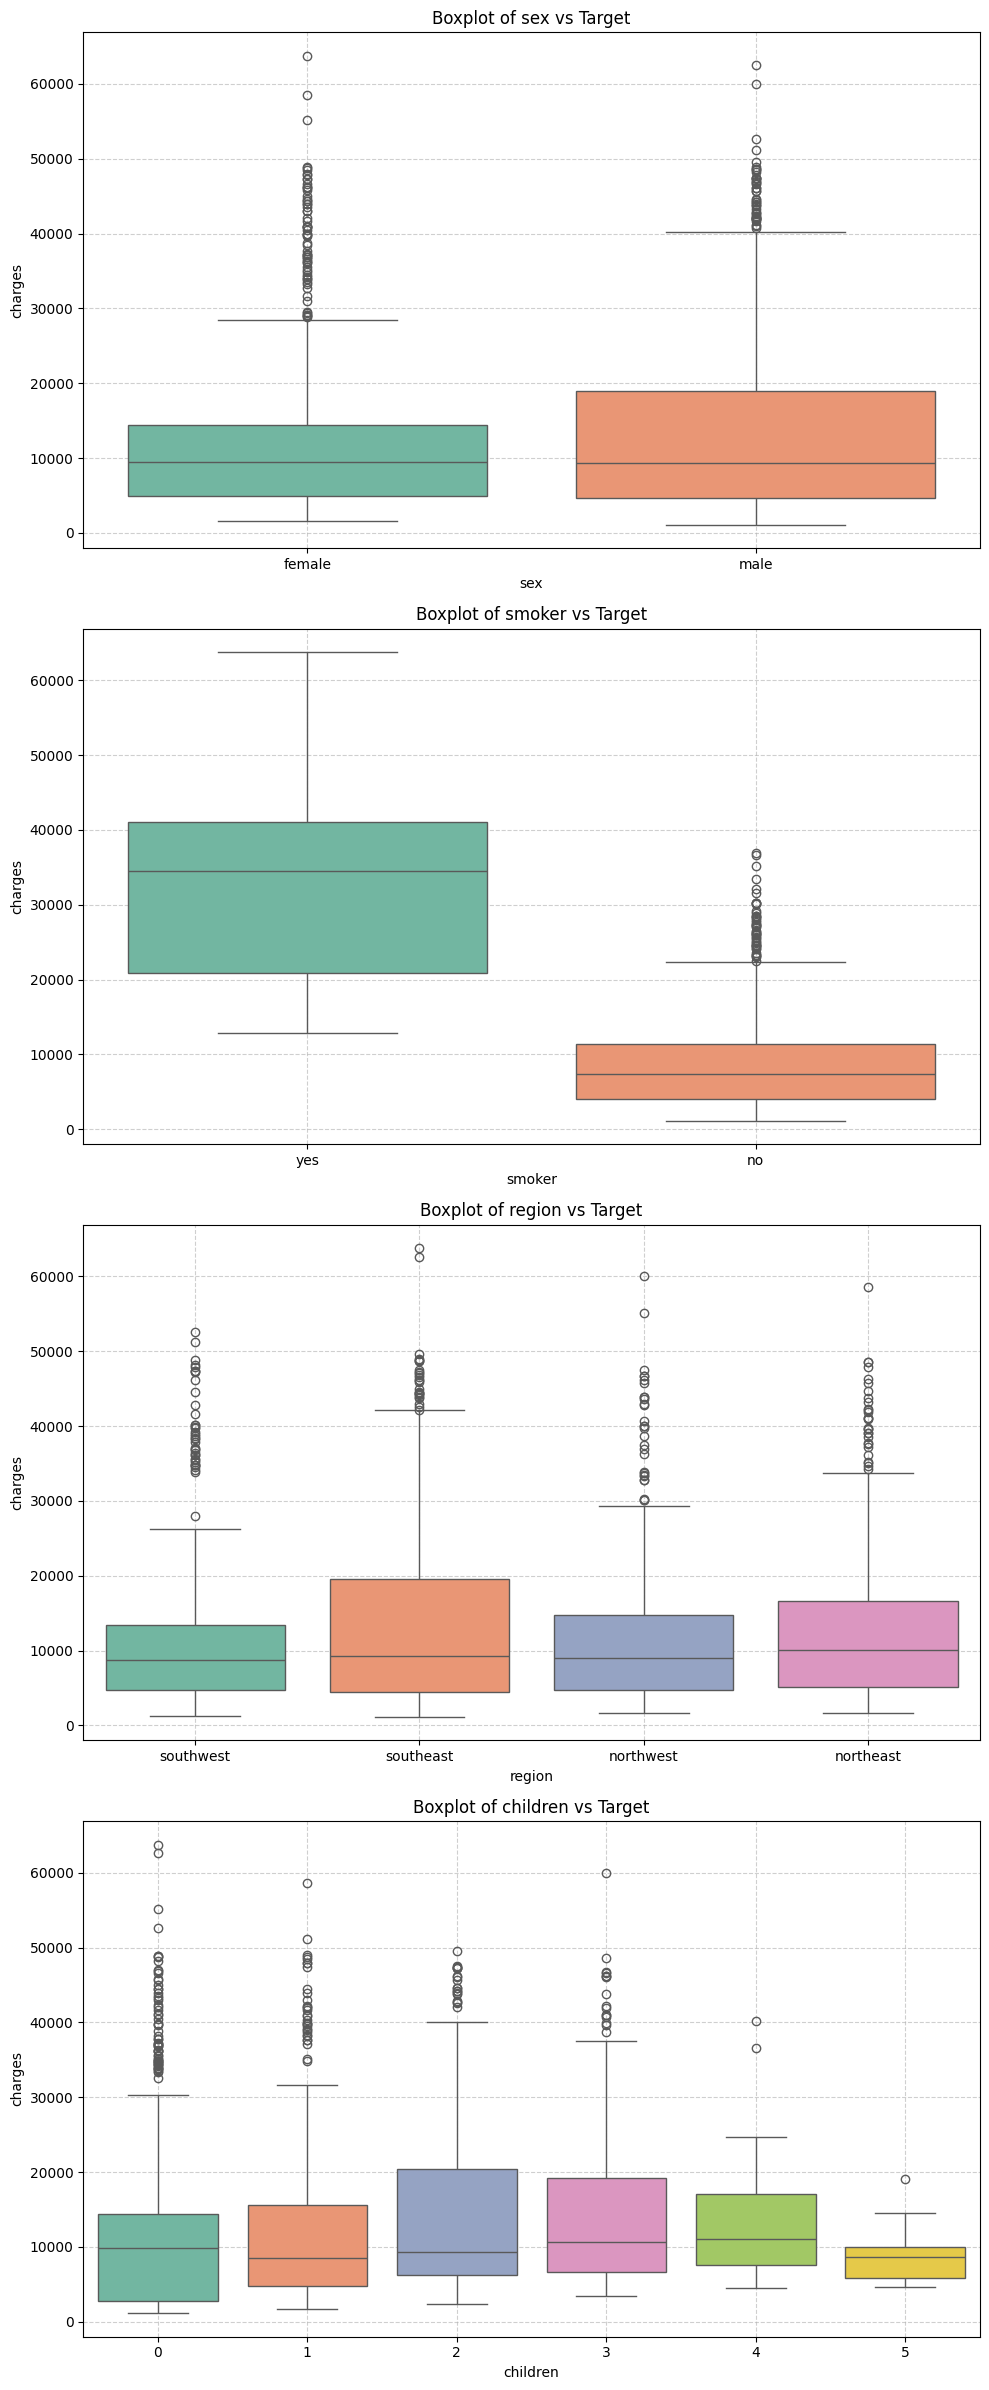

In [28]:
# variables catégorielles
plot_univariate_categorical(X[['sex','smoker','region','children']],y)

* `sex` - Pas de différences significatives de `charges` entre les catégories.
* `smoker` - Les `charges` pour `smoker` == 'yes' sont  plus élevées que  `smoker` == 'no'.
* `region` - Pas de différences significatives de `charges` entre les catégories.
* `children` - Pas de différences significatives de `charges` entre les catégories

## Analyse bivariée des variables explicatives  par rapports à la variable cible

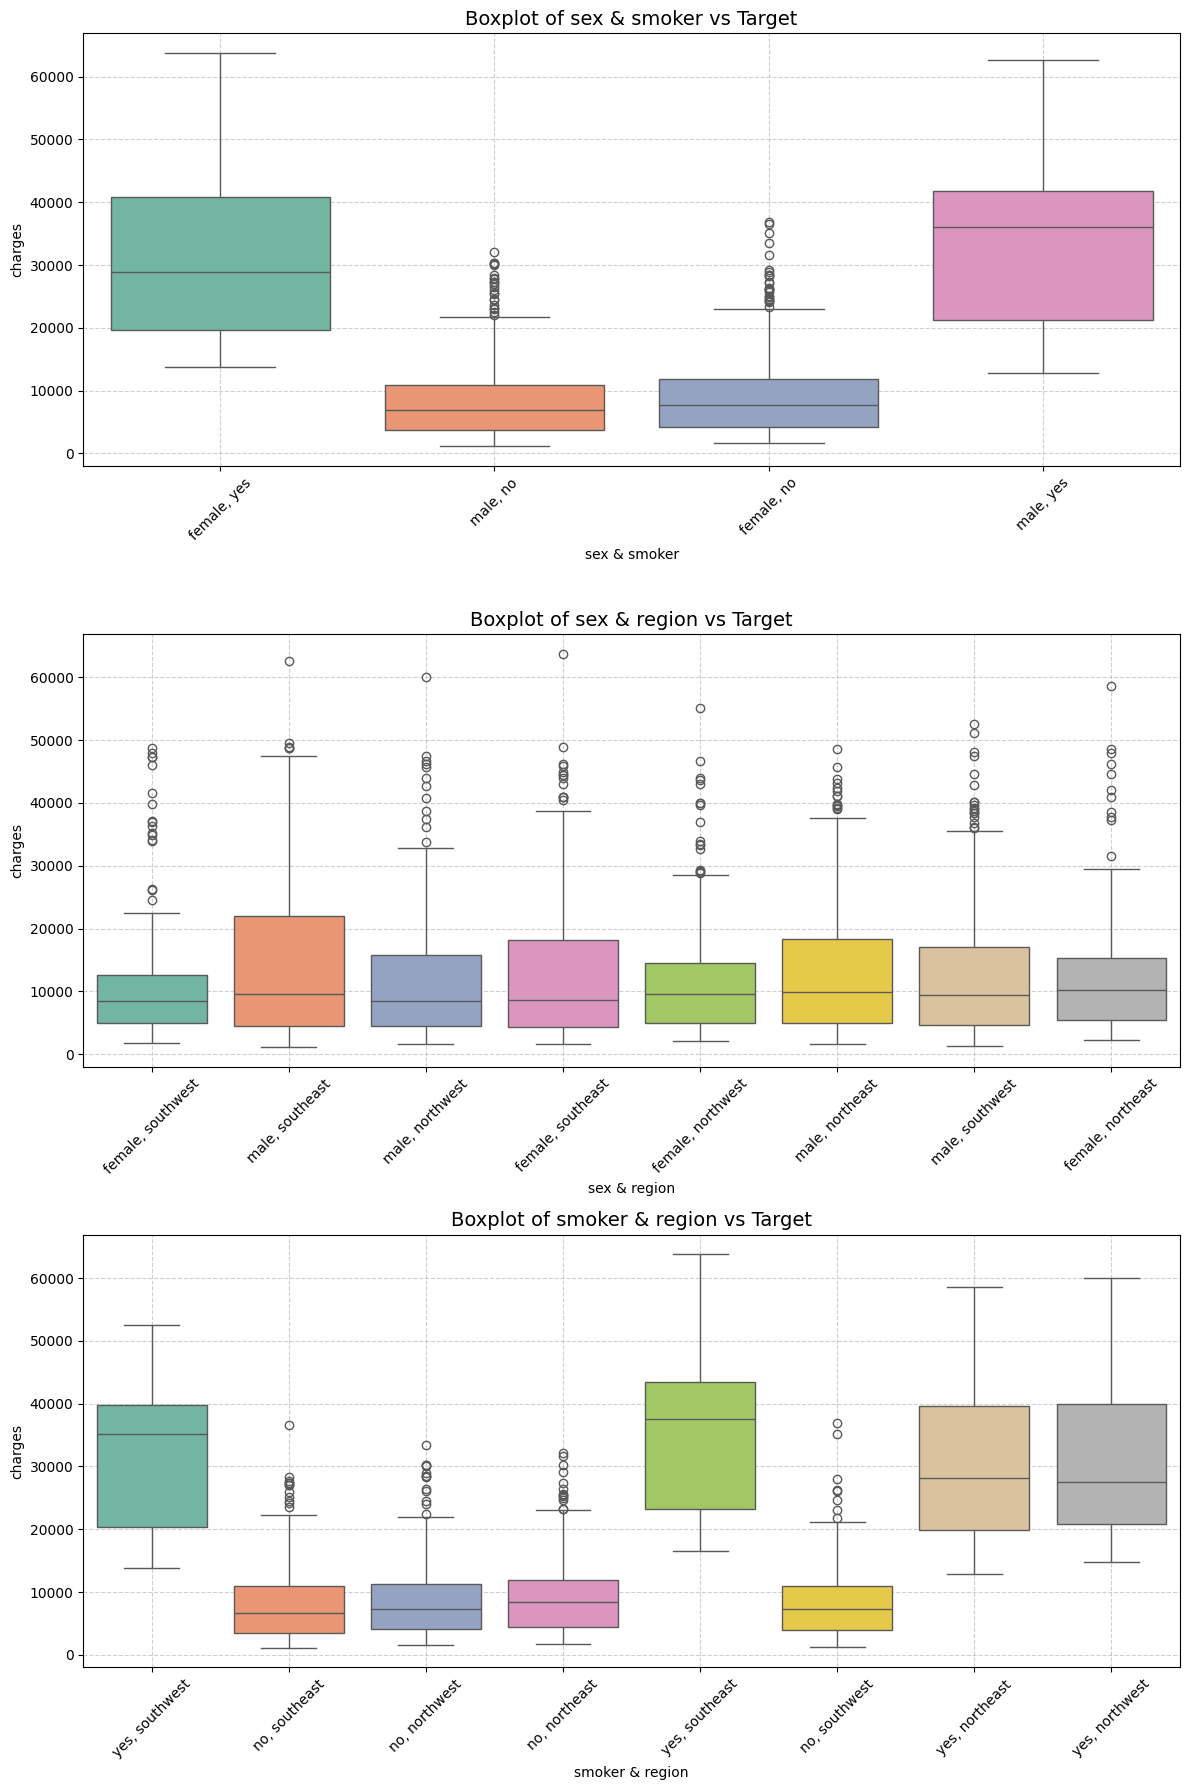

In [47]:
# variables catégorielles 
plot_paired_boxplots(X[['sex','smoker','region']],y)

* `sex-smoker` - La médiane des `charges` est plus élevée pour les hommes fumeurs que pour les femmes fumeuses (36k vs 29k).
* `smoker-region` - La médiane des ``charges`` est plus élevée pour les fumeurs dans le sud-ouest et le sud-est par rapport au nord-est et au nord-ouest (35k et 37k vs 28k et 27k).

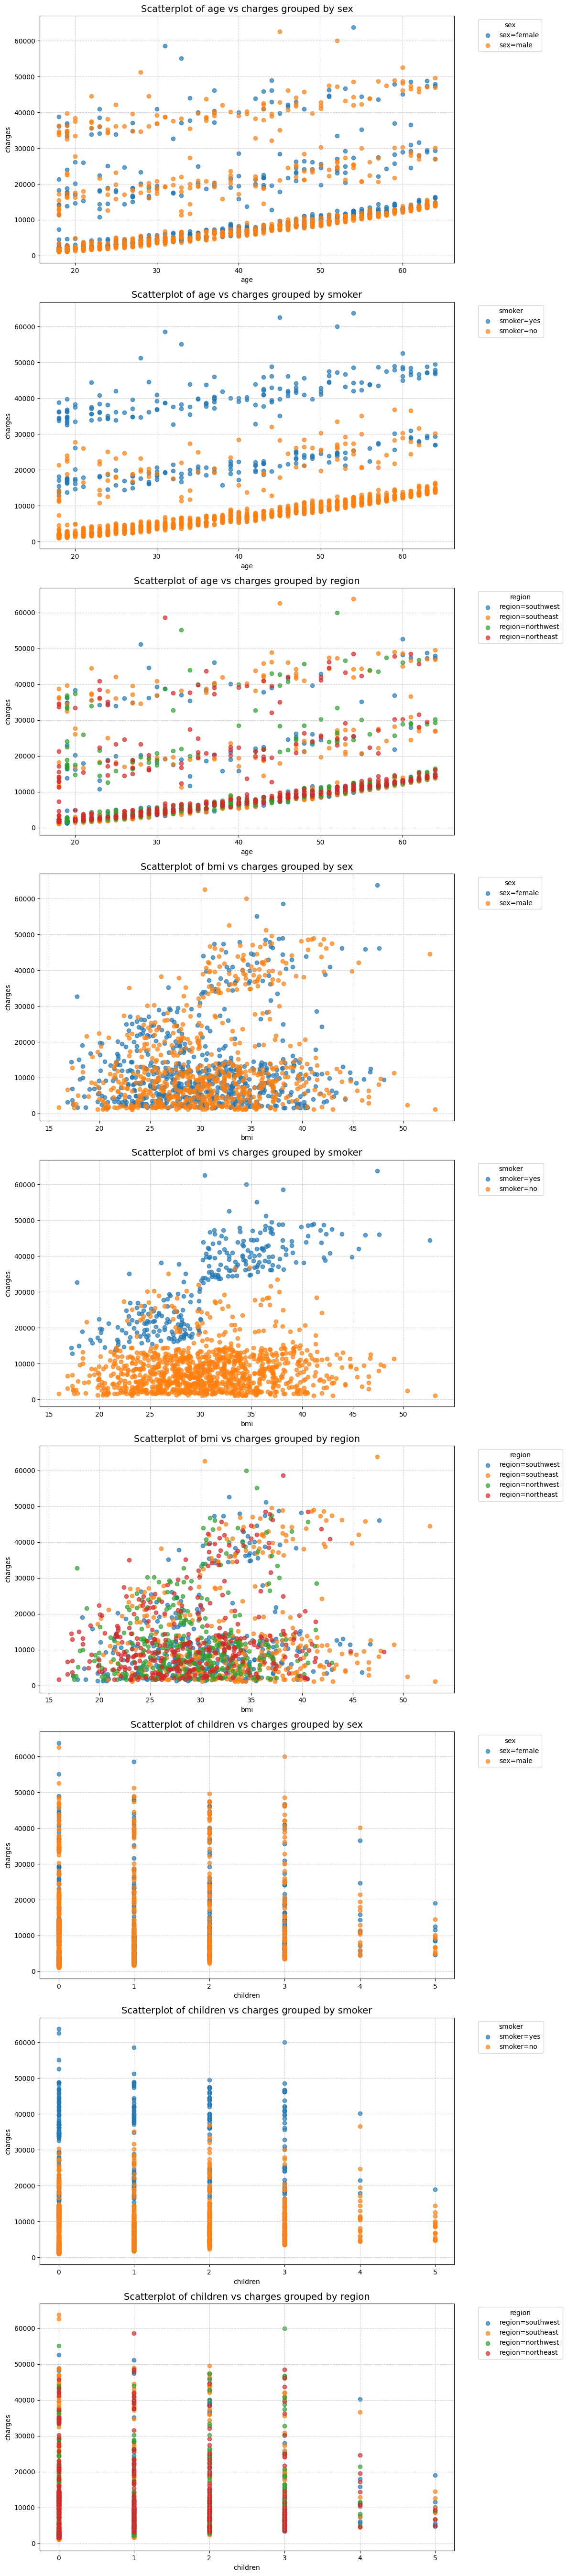

In [7]:
# variables numérique-catégorielles
plot_paired_scatterplots(X,y)

* `age- smoker`- Il y a un groupe (dont age< 50 et smoker= 'non') où tous les bénéficiaires ont des frais de santé inférieurs à 10 000 $ (ce qui est relativement faible par rapport au reste de la population).
* `bmi- smoker`- Il y a un groupe  (dont  bmi> 30 et smoker= 'oui') où tous les bénéficiaires ont des frais de santé supérieurs à 30 000 $

## Colinéarité entre les variables

In [20]:
# variables numériques: test de Pearson
px.imshow(X.select_dtypes(include=np.number).corr())

* Aucune dépendance remarquée entre les variables

In [15]:
# variables catégorielle: test de Chi2
X_chi2 = chi2(X.select_dtypes(object))

In [12]:
X_chi2

,column1,column2,chi_squared,p_value,dof
0,sex,smoker,7.392911,0.006548,1
1,sex,region,0.435137,0.932892,3
2,smoker,region,7.343478,0.061720,3


In [13]:
X_chi2[X_chi2['p_value'] < 0.05]

,column1,column2,chi_squared,p_value,dof
0,sex,smoker,7.392911,0.006548,1


* Les deux variables  `sex & smoker` sont dépendantes

In [16]:
# variables numériques-catégorielles: test d' ANOVA
X_anova = anova(X)

In [17]:
X_anova

,num_column,cat_column,f_stat,p_value
0,age,sex,0.581369,4.459107e-01
1,age,smoker,0.836777,3.604853e-01
2,age,region,0.079782,9.709891e-01
3,bmi,sex,2.878970,8.997637e-02
4,bmi,smoker,0.018792,8.909850e-01
5,bmi,region,39.495057,1.881839e-24
6,children,sex,0.393659,5.304898e-01
7,children,smoker,0.078664,7.791596e-01
8,children,region,0.717493,5.415543e-01


In [18]:
X_anova[X_anova['p_value'] < 0.05]

,num_column,cat_column,f_stat,p_value
5,bmi,region,39.495057,1.881839e-24


* Les deux variables  `bmi & region` sont dépendantes

## Dépendance avec la variable cible

c:\Users\del\Desktop\Nouveau dossier (3)\insurance\mon_package\EDA.py:186: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




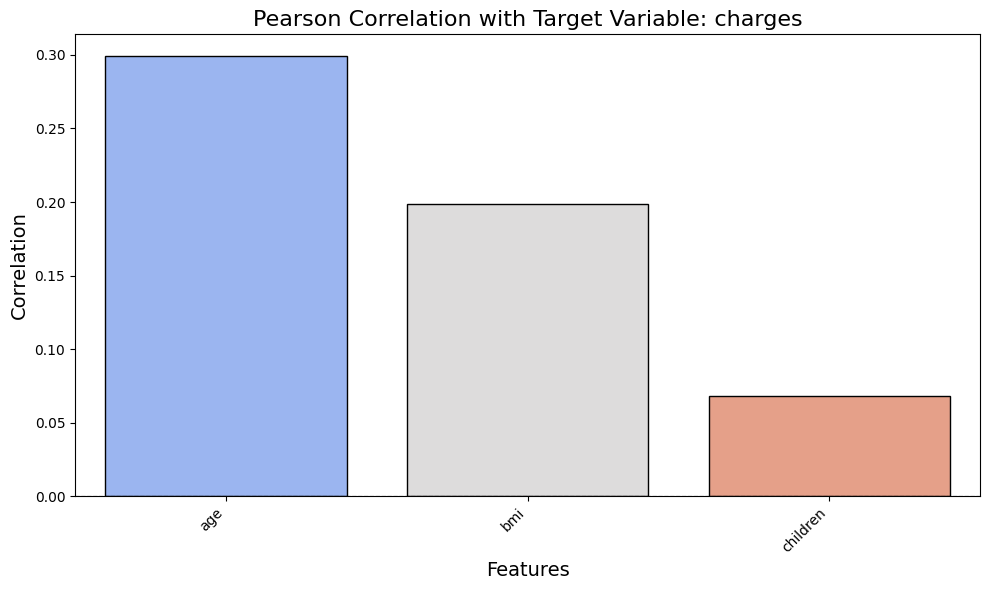

In [22]:
# variables numériques
plot_pearson_wrt_target(X, y)

* La variable `children` a la plus petite valeur de corrélation avec les `charges`

In [27]:
# variables catégorielle
data_anova = anova(data) 
anova_ = data_anova[data_anova['num_column']=='charges']

In [29]:
anova_

,num_column,cat_column,f_stat,p_value
9,charges,sex,4.399702,3.613272e-02
10,charges,smoker,2177.614868,8.271436e-283
11,charges,region,2.969627,3.089336e-02


* Toutes les valeurs de p-values sont inférieurs à 0.05 : les variables catégorielles et les `charges` sont dépendantes

# **Construction d'une Pipeline ML**

### **Régresssion linéaire**

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

### **Supression des variables non nécessaires** 

### Après notre analyse de données exploitoires, la variable `children`est corrélé faibelement avec la variable `charges` (ne contient aucune information sur la variable cible), donc on doit la supprimer
### De plus, notre test $\chi^2$ a suggéré que la caractéristique sex est corrélée à la caractéristique smoker, et notre test ANOVA a suggéré que la caractéristique region est corrélée à la caractéristique bmi. Cela rend les estimateurs instables d'un modèle de régression linéaire, donc on doit  supprimer `sex` et `region`. 

In [23]:
cols_to_drop = ['children', 'region', 'sex']
X_train.drop(cols_to_drop, axis=1, inplace =True)
X_test.drop(cols_to_drop, axis=1, inplace =True)

### **Encoding des varables catégorielles**

In [24]:
ohe = OneHotEncoder(use_cat_names=True)
X_train = ohe.fit_transform(X_train)
X_test = ohe.fit_transform(X_test)

c:\Users\del\anaconda3\envs\projet_python\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\del\anaconda3\envs\projet_python\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


In [25]:
cols_to_drop = ['smoker_no']
X_train.drop(cols_to_drop, axis=1, inplace=True)
X_test.drop(cols_to_drop, axis=1, inplace=True)

### **Transformation de la distribution de la variable cible**

In [26]:
pt = PowerTransformer(method='yeo-johnson')
y_train_t = pt.fit_transform(y_train.values.reshape(-1, 1))[:, 0]
y_test_t = pt.transform(y_test.values.reshape(-1, 1))[:, 0]

<AxesSubplot: >

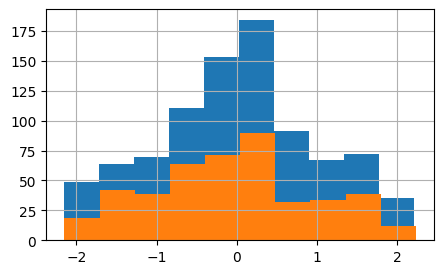

In [27]:
pd.Series(y_train_t).hist(figsize=(5, 3))
pd.Series(y_test_t).hist(figsize=(5, 3))

### **L'entrainement de modèle**

In [28]:
sample_weight = y_train / y_train.min()

In [36]:
lr = LinearRegression()
lr.fit( X_train, y_train_t, sample_weight=sample_weight)

LinearRegression()

In [37]:
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

In [38]:
y_pred_train = pt.inverse_transform(y_pred_train.reshape(-1, 1))[:, 0]
projectpro.checkpoint('1e808c')
y_pred_test = pt.inverse_transform(y_pred_test.reshape(-1, 1))[:, 0]

### **Evaluation de modèle**

In [39]:
base_perf_train = calc_model_performance(y_train, y_pred_train)

In [40]:
base_perf_train

{'Root Mean Squared Error': 5964.030079525293,
 'Mean Squared Error': 35569654.78948248,
 'Mean Absolute Error': 4583.192074027691,
 'Mean Absolute Percentage Error': 0.7487184929524602,
 'R Squared': 0.7572131565075644}

In [41]:
base_perf_test = calc_model_performance(y_test, y_pred_test)

In [43]:
base_perf_test

{'Root Mean Squared Error': 5752.477398059849,
 'Mean Squared Error': 33090996.215189416,
 'Mean Absolute Error': 4534.422635060568,
 'Mean Absolute Percentage Error': 0.756537151185135,
 'R Squared': 0.774191723271553}

### **Normalité des résidus**

In [44]:
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

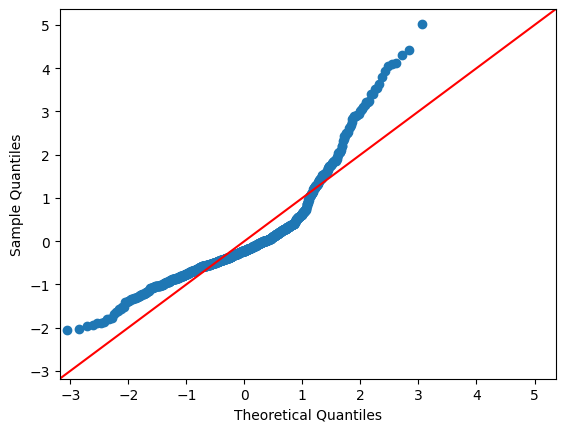

In [45]:
fig = sm.qqplot(residuals_train, fit=True,line='45')

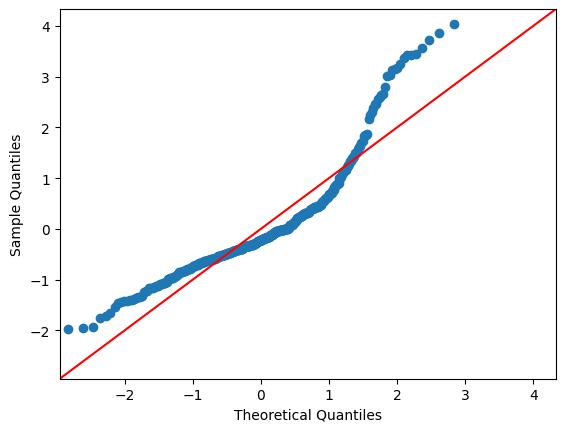

In [46]:
fig = sm.qqplot(residuals_test, fit=True,line='45')

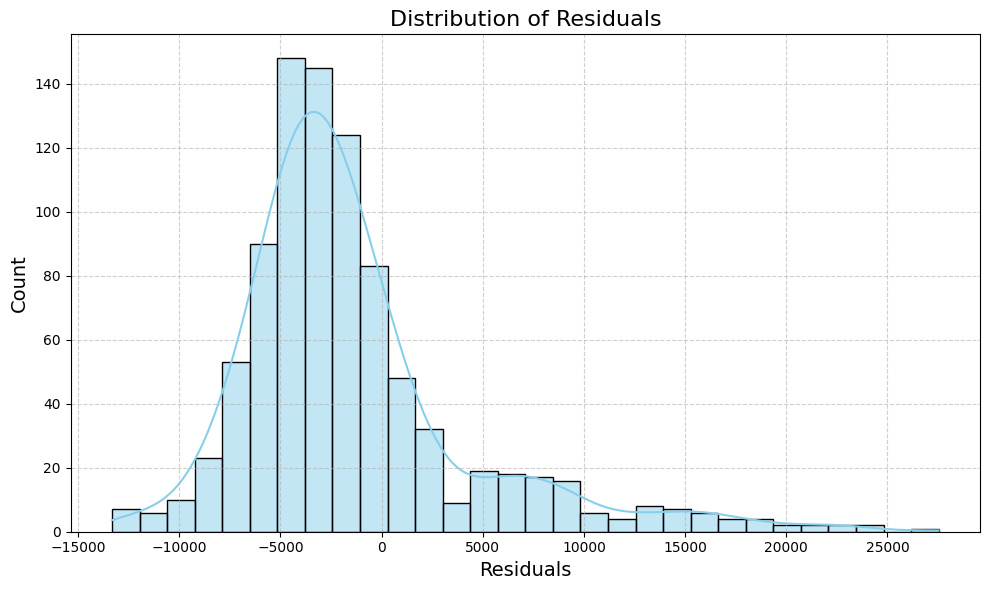

In [47]:
plot_residuals(y_true=y_train, y_pred=y_pred_train)

### **Homoscédasticité**

In [48]:
px.scatter(x=y_train, y=residuals_train)

In [49]:
px.scatter(x=y_test, y=residuals_test)

### **XGBoost**

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

In [52]:
ohe = OneHotEncoder(use_cat_names=True)
X_train = ohe.fit_transform(X_train)
X_test = ohe.transform(X_test)

In [53]:
rfe = RFE(estimator=XGBRegressor())
xgb = XGBRegressor()

In [54]:
steps = [('rfe', rfe),('xgb', xgb)]

In [55]:
pipe = Pipeline(steps)

In [57]:
num_features = X_train.shape[1]
search_spaces = {
    'rfe__n_features_to_select': Integer(1, num_features), 
    'xgb__n_estimators': Integer(1, 500), 
    'xgb__max_depth': Integer(2, 8), 
    'xgb__reg_lambda': Integer(1, 200), 
    'xgb__learning_rate': Real(0, 1), 
    'xgb__gamma': Real(0, 2000) 
}

In [58]:
xgb_bs_cv = BayesSearchCV(
    estimator=pipe, 
    search_spaces=search_spaces, 
    scoring='neg_root_mean_squared_error', 
    n_iter=75, 
    cv=3, 
    n_jobs=-1, 
    verbose=1, 
    random_state=0 
)

In [59]:
xgb_bs_cv.fit(X_train, y_train,)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

BayesSearchCV(cv=3,
              estimator=Pipeline(steps=[('rfe',
                                         RFE(estimator=XGBRegressor(base_score=None,
                                                                    booster=None,
                                                                    callbacks=None,
                                                                    colsample_bylevel=None,
                                                                    colsample_bynode=None,
                                                                    colsample_bytree=None,
                                                                    early_stopping_rounds=None,
                                                                    enable_categorical=False,
                                                                    eval_metric=None,
                                                                    feature_types=None,
                                                                    gamma=None,
                                                                    gpu_id=None,
                                                                    grow_policy=None,
                                                                    importance_type=None,
                                                                    interaction...
                             'xgb__gamma': Real(low=0, high=2000, prior='uniform', transform='normalize'),
                             'xgb__learning_rate': Real(low=0, high=1, prior='uniform', transform='normalize'),
                             'xgb__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'xgb__n_estimators': Integer(low=1, high=500, prior='uniform', transform='normalize'),
                             'xgb__reg_lambda': Integer(low=1, high=200, prior='uniform', transform='normalize')},
              verbose=1)

### **Evaluation de modèle**

In [60]:
cv_results = pd.DataFrame(xgb_bs_cv.cv_results_).sort_values('rank_test_score')

In [62]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__n_features_to_select,param_xgb__gamma,param_xgb__learning_rate,param_xgb__max_depth,param_xgb__n_estimators,param_xgb__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
55,1.028055,0.048585,0.013311,0.001916,7,991.923821,0.268786,2,34,22,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-4034.487909,-4881.456123,-4796.130211,-4570.691414,380.749941,1
37,0.498944,0.005688,0.000343,0.000485,7,1633.386365,0.337266,2,39,1,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-4056.187713,-4935.986219,-4758.550971,-4583.574968,379.889285,2
39,0.987399,0.039027,0.006660,0.005710,7,1318.669176,0.33411,2,39,1,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-4102.224375,-4909.525475,-4751.886284,-4587.878711,349.387683,3
27,0.448362,0.008634,0.006537,0.003350,7,938.945425,0.332198,2,39,23,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-4100.658678,-4865.507916,-4800.846608,-4589.004400,346.320112,4
35,0.655027,0.007400,0.008341,0.002367,7,40.237344,0.331474,2,39,1,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-4089.242806,-4901.437827,-4789.488929,-4593.389854,359.403509,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21,1.043699,0.009336,0.007089,0.003698,1,493.468716,0.372326,2,38,97,"{'rfe__n_features_to_select': 1, 'xgb__gamma':...",-7472.217014,-7831.368611,-7537.015104,-7613.533576,156.287715,71
12,0.526193,0.017121,0.005882,0.000561,7,517.982549,0.724904,2,1,50,"{'rfe__n_features_to_select': 7, 'xgb__gamma':...",-11053.574929,-9677.749400,-10559.357395,-10430.227241,569.051796,72
15,0.619824,0.000596,0.004434,0.005401,5,1023.281738,0.574388,3,1,57,"{'rfe__n_features_to_select': 5, 'xgb__gamma':...",-12786.871826,-11210.818774,-12129.979514,-12042.556705,646.383718,73
10,0.094883,0.003357,0.003404,0.001251,11,711.798963,0.308168,2,1,187,"{'rfe__n_features_to_select': 11, 'xgb__gamma'...",-16874.786608,-14897.826640,-15726.175854,-15832.929701,810.612923,74


In [63]:
y_pred_train_xgb = xgb_bs_cv.predict(X_train)
y_pred_test_xgb = xgb_bs_cv.predict(X_test)

In [65]:
xgb_perf_train = calc_model_performance(y_train, y_pred_train_xgb)

In [66]:
xgb_perf_train

{'Root Mean Squared Error': 4284.546568257306,
 'Mean Squared Error': 18357339.29556546,
 'Mean Absolute Error': 2405.0950497709878,
 'Mean Absolute Percentage Error': 0.2667787168640216,
 'R Squared': 0.8746987990502554}

In [67]:
xgb_perf_test = calc_model_performance(y_test, y_pred_test_xgb)

In [68]:
xgb_perf_test

{'Root Mean Squared Error': 4503.971470169557,
 'Mean Squared Error': 20285759.004101317,
 'Mean Absolute Error': 2539.2389091287296,
 'Mean Absolute Percentage Error': 0.2927060804241973,
 'R Squared': 0.8615728504195934}

### **Comparaison de performance entre le modèle de base RL et le nouveau mdèle XGBoost**

In [69]:
perf_comp_train = compare_model_performance(base_perf_train, xgb_perf_train)
perf_comp_test = compare_model_performance(base_perf_test, xgb_perf_test)

In [70]:
perf_comp_train

,base,new,abs_improvement,perc_improvement
Root Mean Squared Error,5964.03,4284.55,-1679.48,-28.16
Mean Squared Error,35569654.79,18357339.30,-17212315.49,-48.39
Mean Absolute Error,4583.19,2405.10,-2178.09,-47.52
Mean Absolute Percentage Error,0.75,0.27,-0.48,-64.00
R Squared,0.76,0.87,0.11,14.47


In [71]:
perf_comp_test

,base,new,abs_improvement,perc_improvement
Root Mean Squared Error,5752.48,4503.97,-1248.51,-21.70
Mean Squared Error,33090996.22,20285759.00,-12805237.22,-38.70
Mean Absolute Error,4534.42,2539.24,-1995.18,-44.00
Mean Absolute Percentage Error,0.76,0.29,-0.47,-61.84
R Squared,0.77,0.86,0.09,11.69
